In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Set a professional plot style for all charts
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150 # Create high-resolution images

# Define the folder where all images will be saved
OUTPUT_VISUALS_DIR = '../output/visuals'
os.makedirs(OUTPUT_VISUALS_DIR, exist_ok=True)
print(f"All visuals will be saved to: {OUTPUT_VISUALS_DIR}")

# --- Load the Final Data ---
# We load the two key data files created by your pipeline
try:
    # This file has all features, needed for some EDA plots
    df_features = pd.read_csv('../output/processed_data/analysis_ready_data.csv')
    # This file has the final scores and classes
    df_final = pd.read_csv('../output/test_TeamSamurai.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: Could not find data files. Please run Notebooks 0 and 2 first.")
    df_features = None

All visuals will be saved to: ../output/visuals
Data loaded successfully.


Chart saved: scoring_engine_validation.png


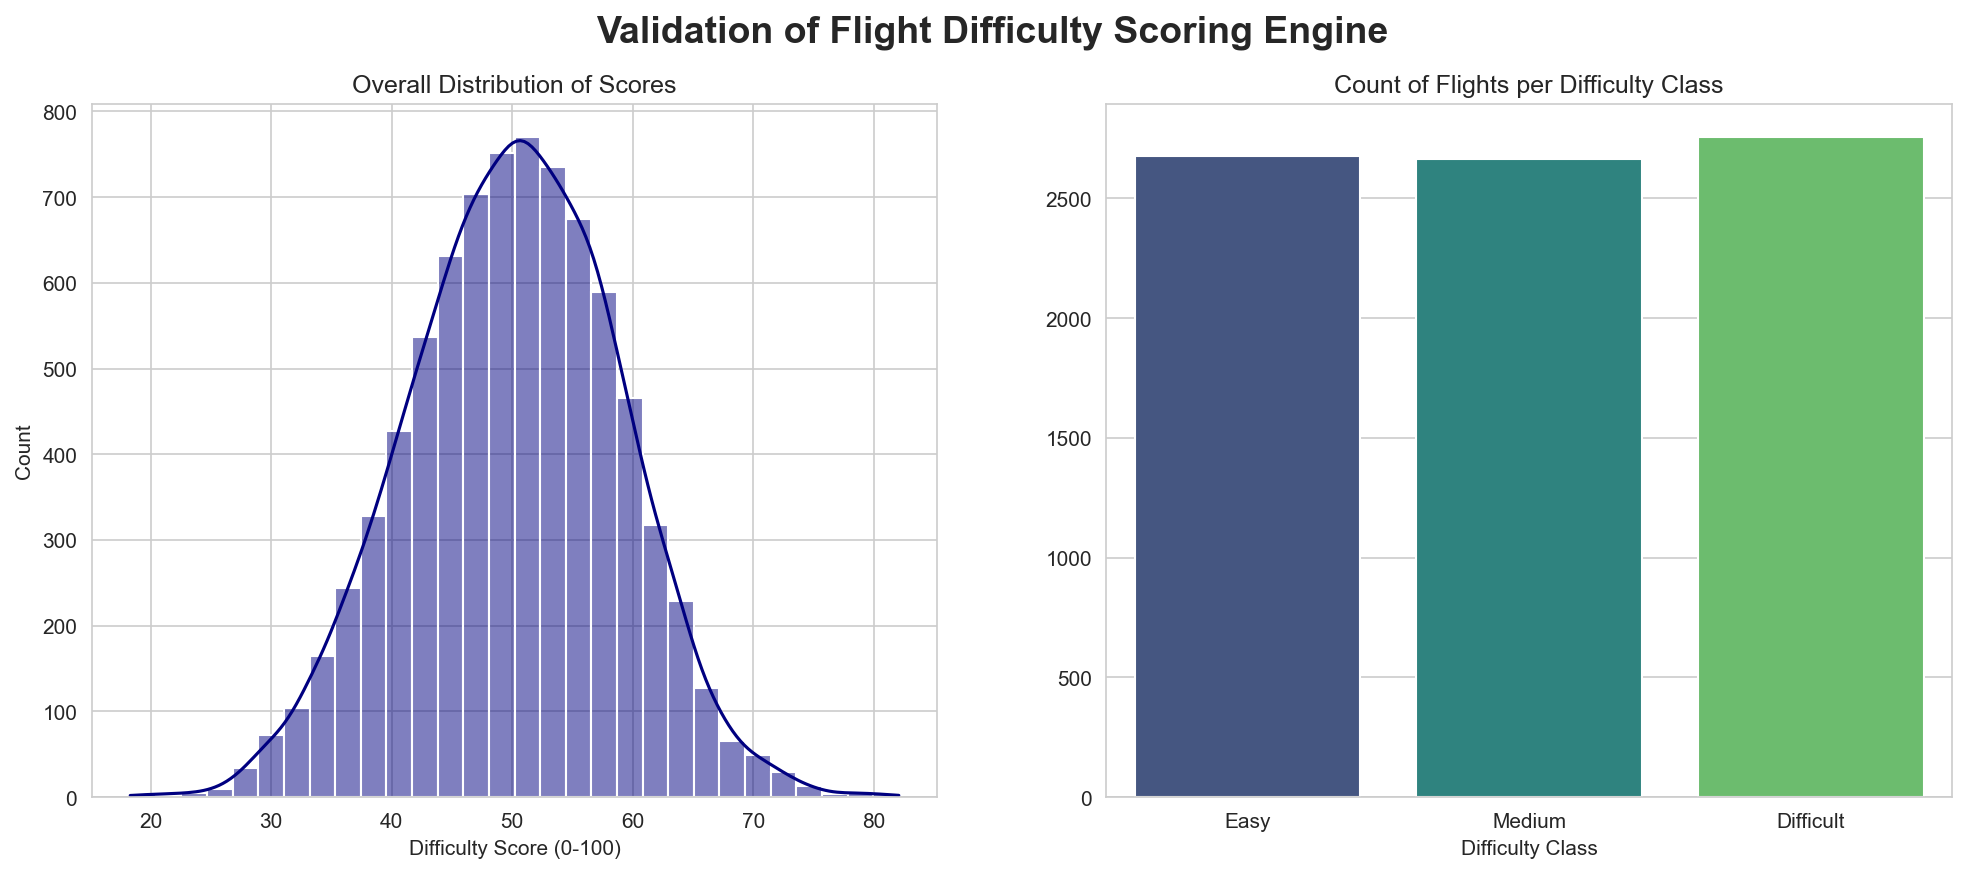

In [2]:
# Cell 4: Scoring Engine Validation Plot
if df_final is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Validation of Flight Difficulty Scoring Engine', fontsize=18, weight='bold')

    # Plot 1: Distribution of the Difficulty Score
    sns.histplot(df_final['difficulty_score'], bins=30, kde=True, ax=axes[0], color='navy')
    axes[0].set_title('Overall Distribution of Scores')
    axes[0].set_xlabel('Difficulty Score (0-100)')

    # Plot 2: Count of Flights in Each Class
    class_counts = df_final['difficulty_class'].value_counts().reindex(['Easy', 'Medium', 'Difficult'])
    sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='viridis', ax=axes[1], legend=False)
    axes[1].set_title('Count of Flights per Difficulty Class')
    axes[1].set_xlabel('Difficulty Class')

    # Save the combined figure
    save_path = os.path.join(OUTPUT_VISUALS_DIR, 'scoring_engine_validation.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Chart saved: scoring_engine_validation.png")
    plt.show()

Chart saved: top_difficult_destinations.png


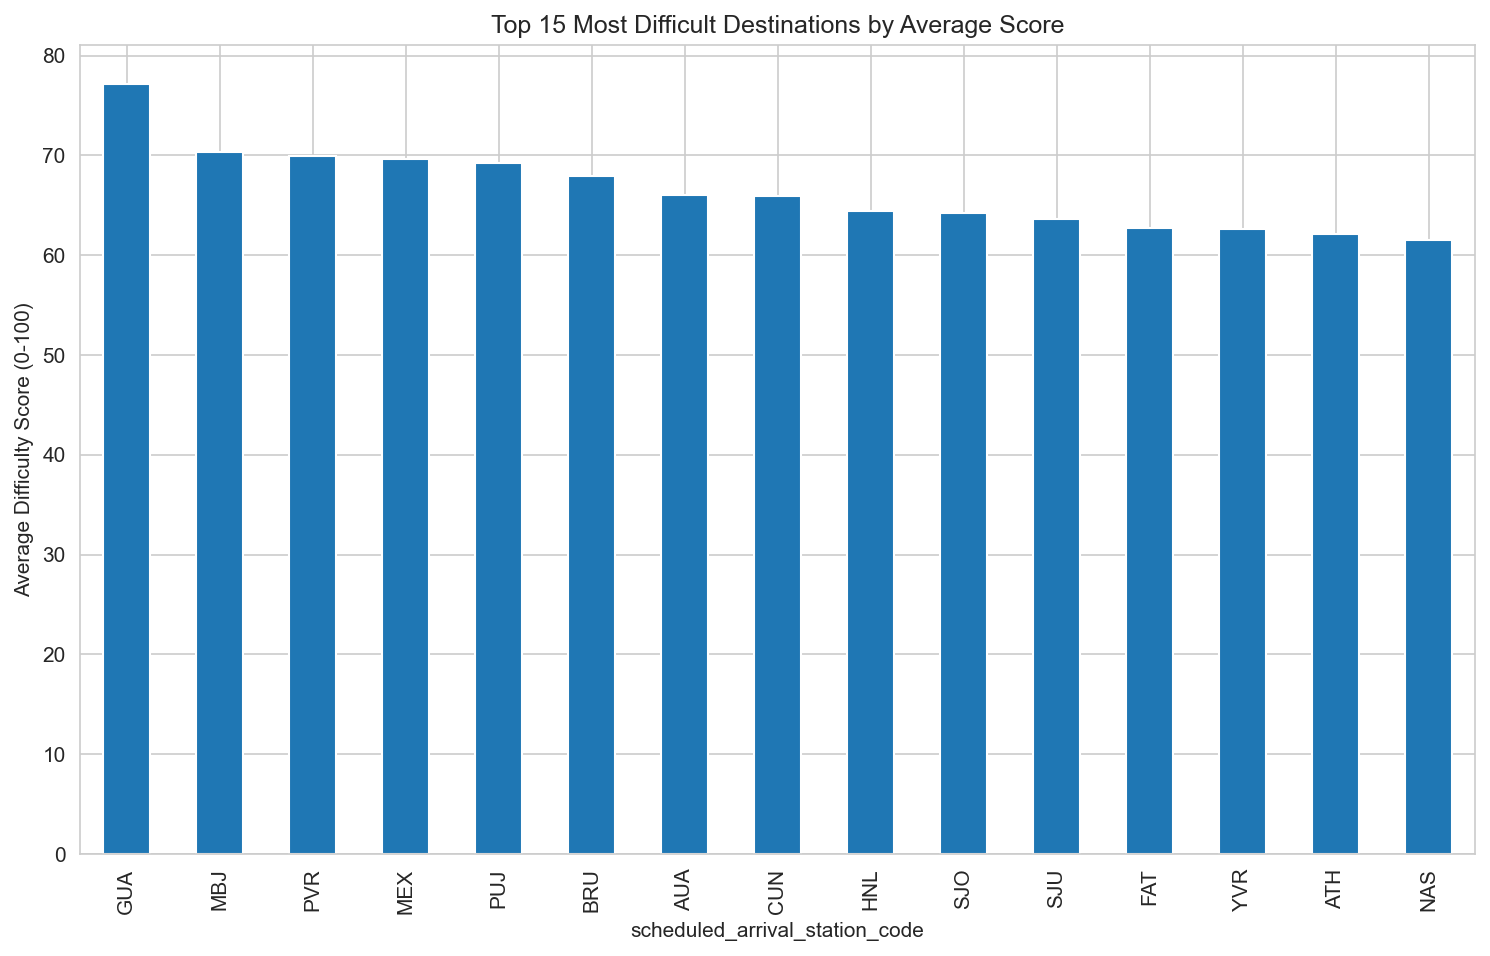

In [3]:
# Cell 6: Top Difficult Destinations Plot
if df_final is not None:
    dest_summary = df_final.groupby('scheduled_arrival_station_code')['difficulty_score'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 7))
    dest_summary.head(15).plot(kind='bar')
    plt.title('Top 15 Most Difficult Destinations by Average Score')
    plt.ylabel('Average Difficulty Score (0-100)')
    
    save_path = os.path.join(OUTPUT_VISUALS_DIR, 'top_difficult_destinations.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Chart saved: top_difficult_destinations.png")
    plt.show()

Chart saved: destination_difficulty_profiles.png


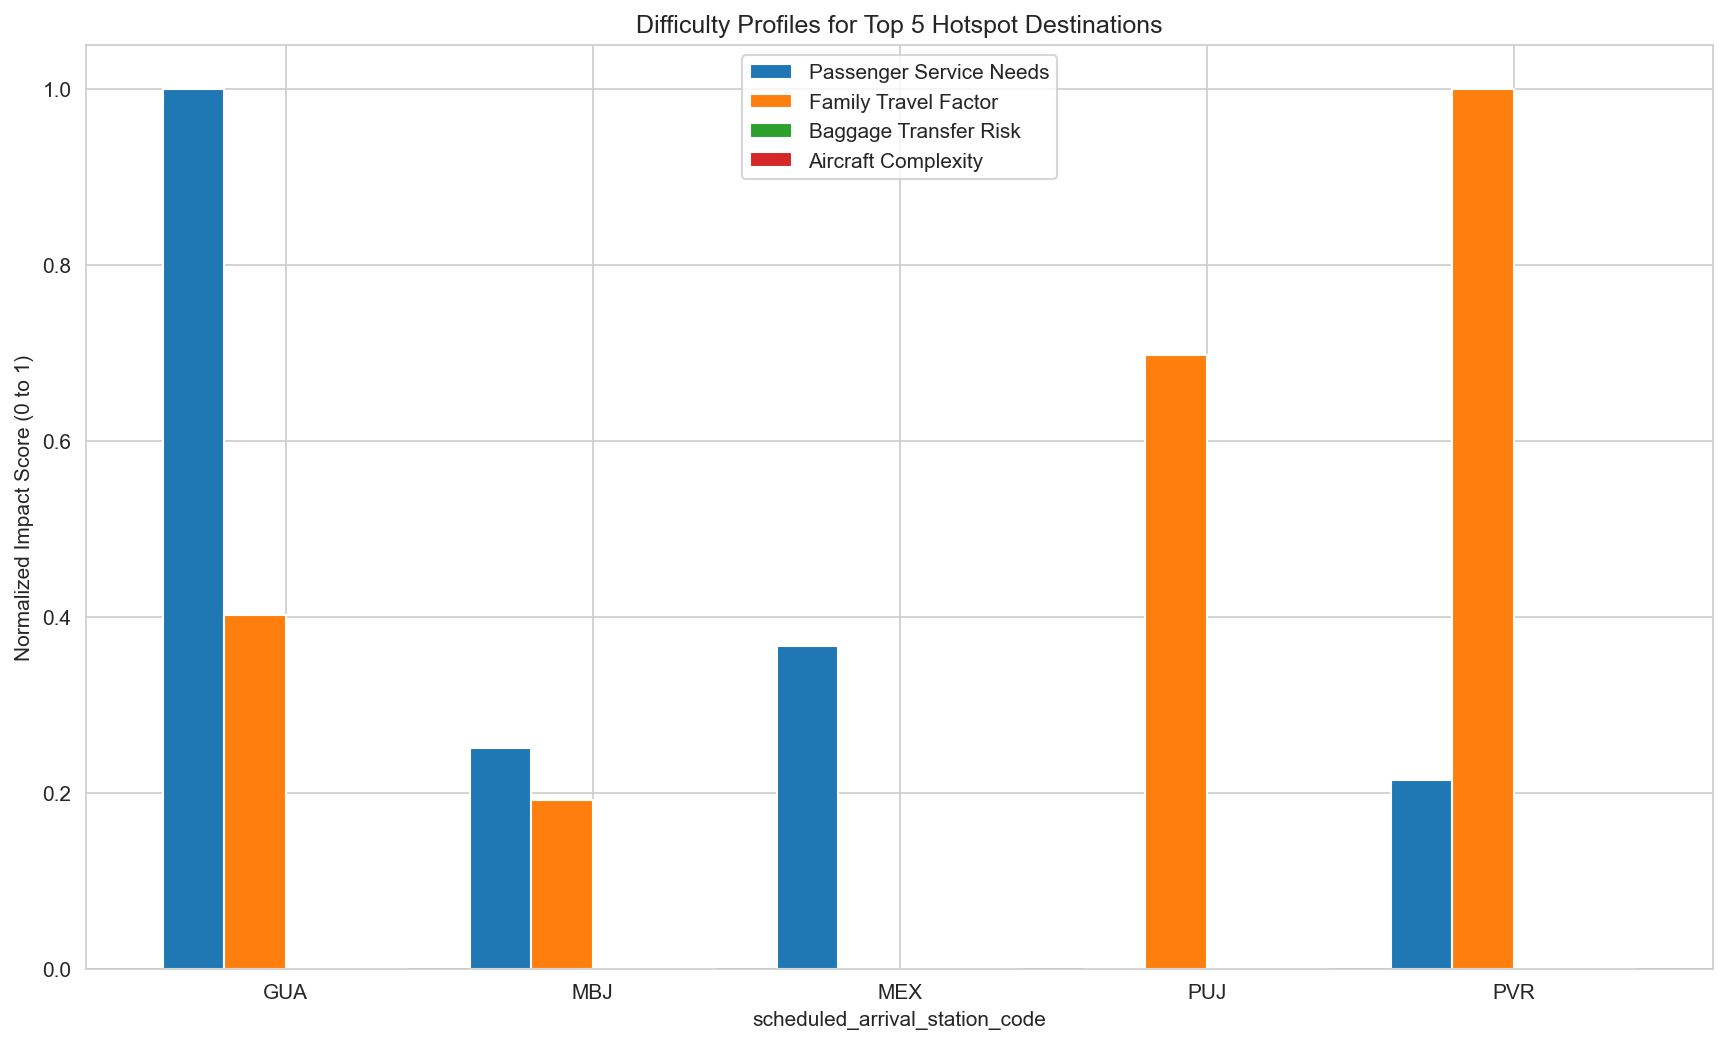

In [4]:
# Cell 7: Destination Difficulty Profiles Plot
if df_final is not None:
    top_5_dests = dest_summary.head(5).index
    driver_features = {
        'Passenger Service Needs': 'ssr_per_pax', 'Family Travel Factor': 'child_ratio',
        'Baggage Transfer Risk': 'is_high_risk_transfer', 'Aircraft Complexity': 'fleet_complexity_score'
    }
    driver_summary = df_final[df_final['scheduled_arrival_station_code'].isin(top_5_dests)].groupby('scheduled_arrival_station_code')[list(driver_features.values())].mean()
    driver_summary.columns = driver_features.keys()

    from sklearn.preprocessing import MinMaxScaler
    normalized_driver_summary = pd.DataFrame(MinMaxScaler().fit_transform(driver_summary),
                                             index=driver_summary.index, columns=driver_summary.columns)

    normalized_driver_summary.plot(kind='bar', figsize=(14, 8), width=0.8)
    plt.title('Difficulty Profiles for Top 5 Hotspot Destinations')
    plt.ylabel('Normalized Impact Score (0 to 1)')
    plt.xticks(rotation=0)
    
    save_path = os.path.join(OUTPUT_VISUALS_DIR, 'destination_difficulty_profiles.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Chart saved: destination_difficulty_profiles.png")
    plt.show()

Chart saved: difficulty_by_hour.png


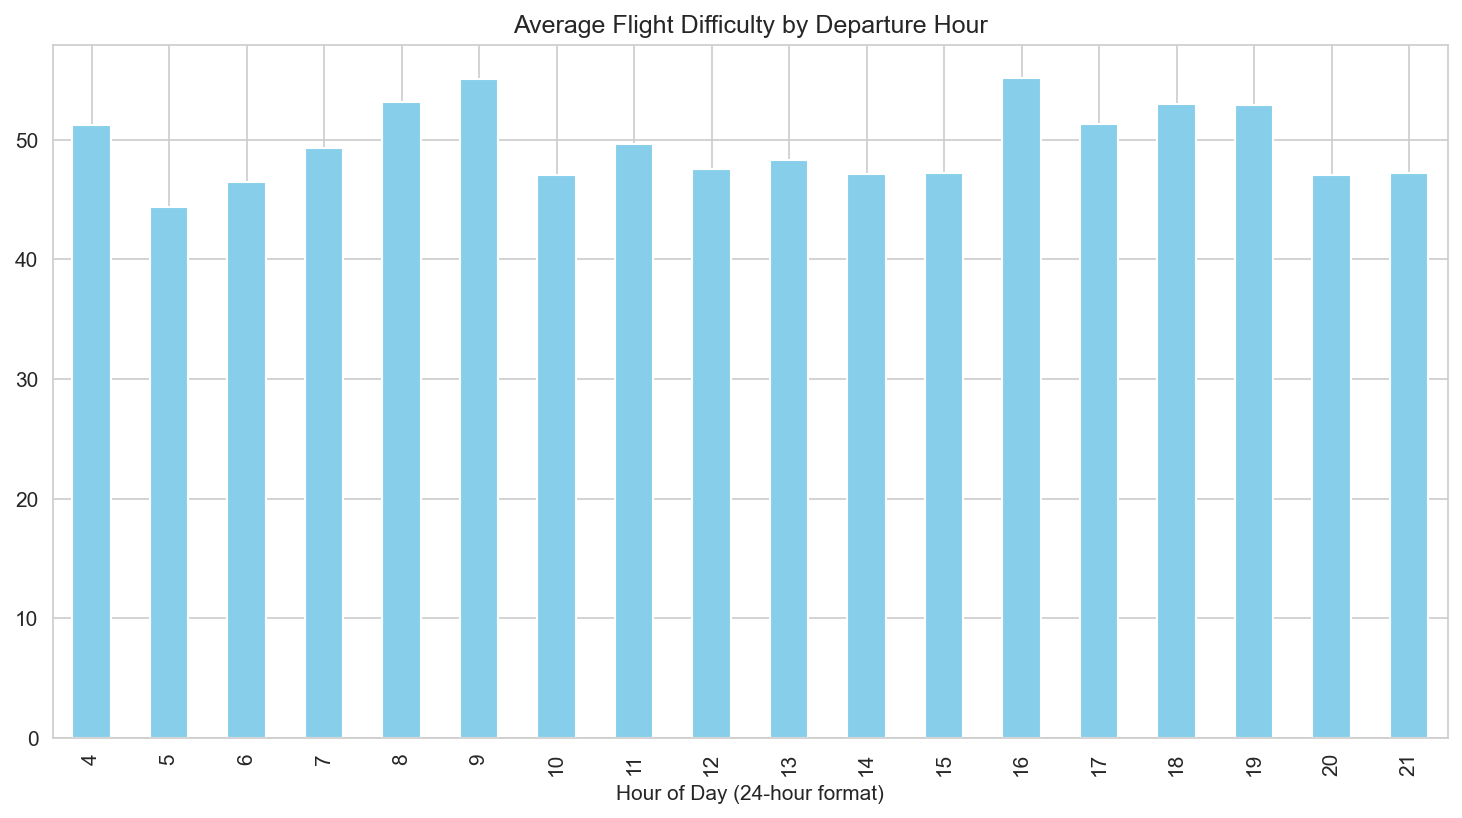

In [5]:
# Cell 8: Difficulty by Hour Plot
if df_final is not None:
    hourly_difficulty = df_final.groupby('departure_hour')['difficulty_score'].mean()
    
    plt.figure(figsize=(12, 6))
    hourly_difficulty.plot(kind='bar', color='skyblue')
    plt.title('Average Flight Difficulty by Departure Hour')
    plt.xlabel('Hour of Day (24-hour format)')
    
    save_path = os.path.join(OUTPUT_VISUALS_DIR, 'difficulty_by_hour.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Chart saved: difficulty_by_hour.png")
    plt.show()

Chart saved: ml_feature_importance.png


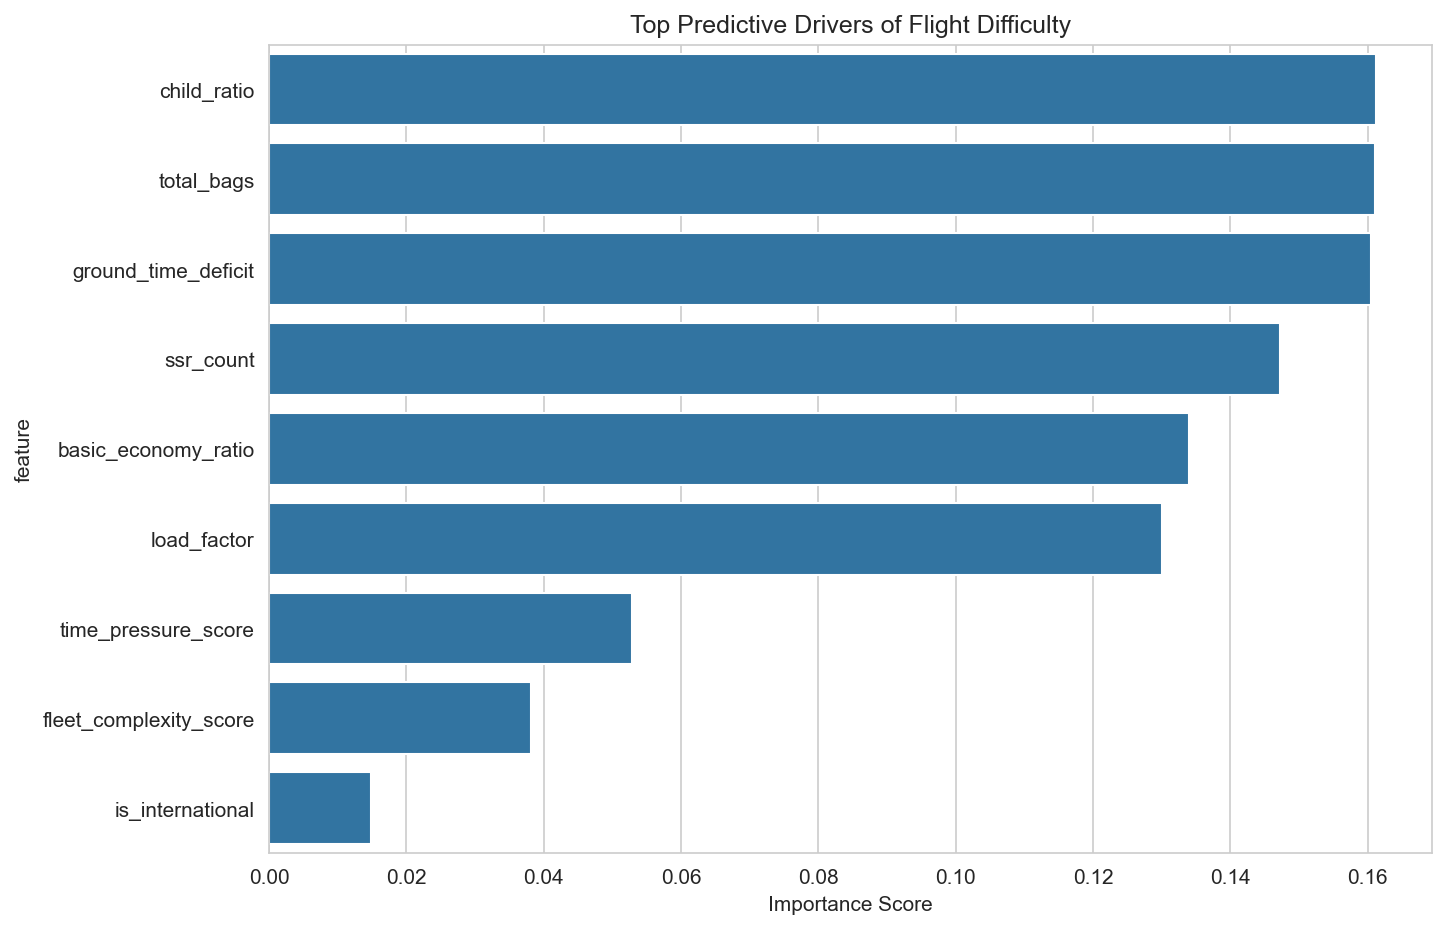

In [7]:
# Cell 11: Feature Importance Plot
if df_final is not None:
    # This is a recreation of the ML analysis to get the feature importances
    from sklearn.ensemble import RandomForestClassifier
    features = [
        'load_factor', 'ground_time_deficit', 'ssr_count', 'total_bags',
        'fleet_complexity_score', 'time_pressure_score', 'is_international',
        'child_ratio', 'basic_economy_ratio'
    ]
    target = 'difficulty_class'
    
    X = df_final[features]
    y = df_final[target]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X, y) # Fit on the full dataset for final importance scores
    
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 7))
    sns.barplot(data=feature_importances, x='importance', y='feature')
    plt.title('Top Predictive Drivers of Flight Difficulty')
    plt.xlabel('Importance Score')
    
    save_path = os.path.join(OUTPUT_VISUALS_DIR, 'ml_feature_importance.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Chart saved: ml_feature_importance.png")
    plt.show()